In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("Online_Retail.csv", encoding="ISO-8859-1")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [3]:

df = df.dropna(subset=['CustomerID'])
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df['CustomerID'] = df['CustomerID'].astype(int)


In [4]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


/tmp/ipython-input-876306190.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [5]:

df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,134,1,1,10.50
1,12346,74,1,77183.60
2,12347,65,2,1187.18
3,12348,67,2,1120.24
4,12350,58,1,334.40


In [6]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,134,1,1,10.50,4,1,1,411
1,12346,74,1,77183.60,1,1,4,114
2,12347,65,2,1187.18,2,3,4,234
3,12348,67,2,1120.24,2,3,4,234
4,12350,58,1,334.40,2,1,2,212


In [7]:
def segment_customer(row):
    if row['RFM_Score'] == '444':
        return 'Champions'
    elif row['R_Score'] == '4' and row['F_Score'] == '4':
        return 'Loyal Customers'
    elif row['R_Score'] == '4':
        return 'Recent Customers'
    elif row['F_Score'] == '4':
        return 'Frequent Buyers'
    elif row['M_Score'] == '4':
        return 'Big Spenders'
    elif row['R_Score'] == '1':
        return 'At Risk'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,134,1,1,10.50,4,1,1,411,Others
1,12346,74,1,77183.60,1,1,4,114,Others
2,12347,65,2,1187.18,2,3,4,234,Others
3,12348,67,2,1120.24,2,3,4,234,Others
4,12350,58,1,334.40,2,1,2,212,Others


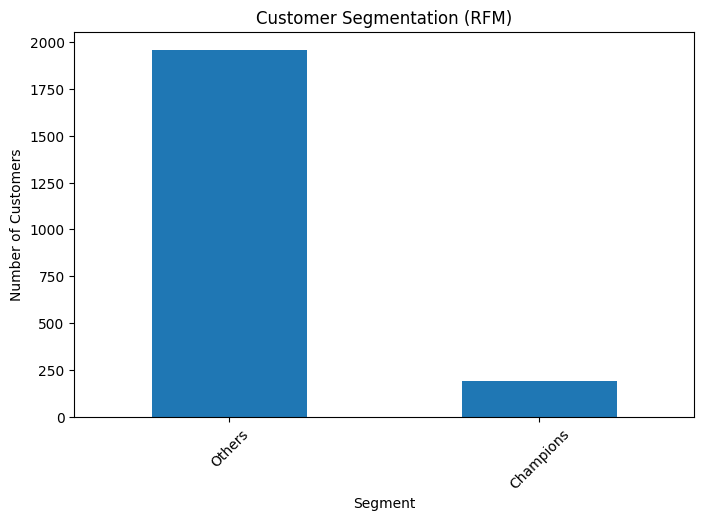

In [8]:
segment_counts = rfm['Segment'].value_counts()

plt.figure(figsize=(8,5))
segment_counts.plot(kind='bar')
plt.title("Customer Segmentation (RFM)")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.show()


In [9]:
rfm.to_csv("rfm_segments.csv", index=False)
